In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'figure.autolayout': True})

ram_dir = '/Users/sebastian/Dropbox/projects/ai-thermostability/code/src/ml_modules/activation_map/temp'

In [44]:
save = True

A0A061ACH8-AFv4_ram_no_relu.npy


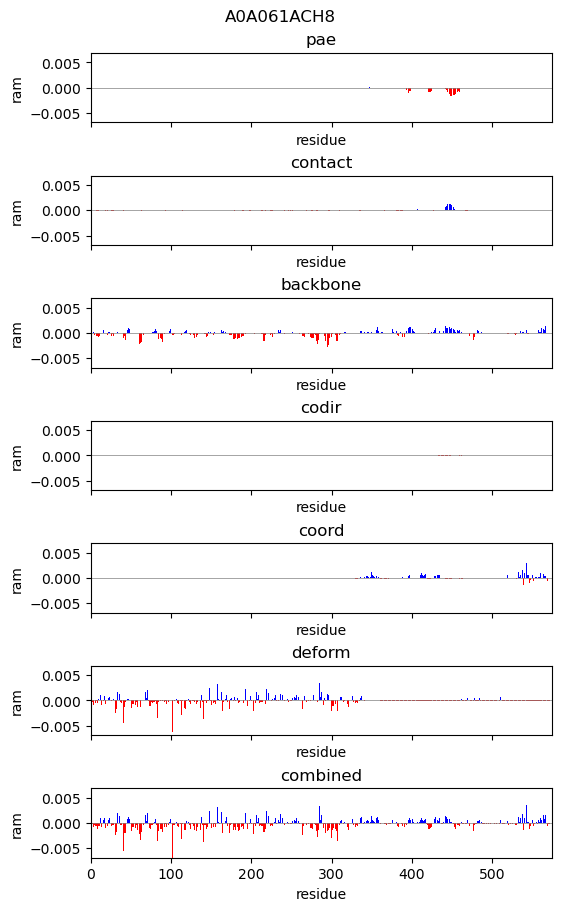

A0A087WR70-AFv4_ram_no_relu.npy


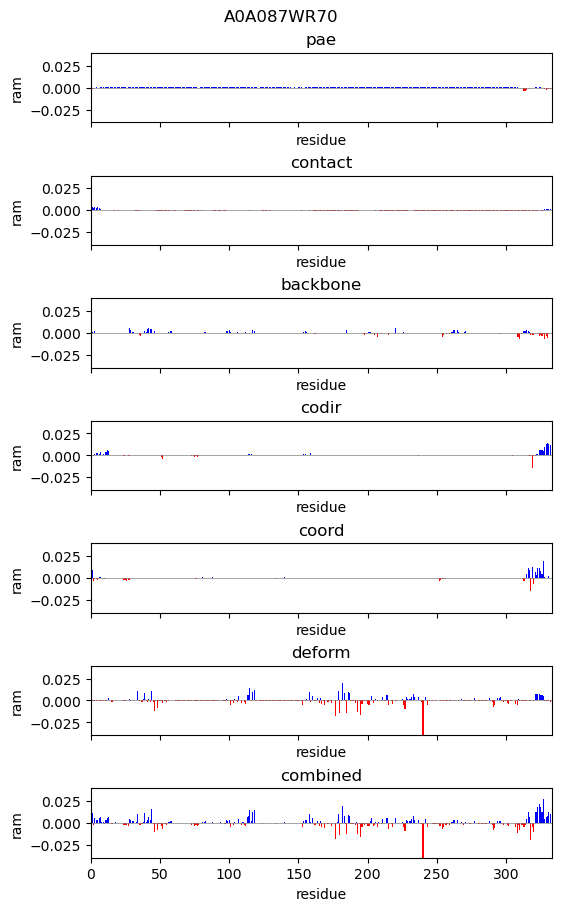

A0A023T778-AFv4_ram_no_relu.npy


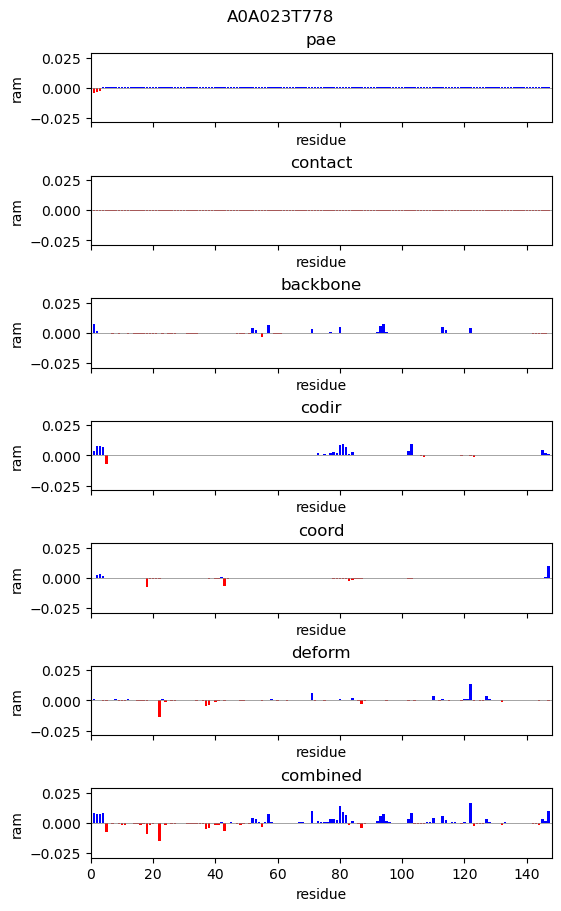

A0A087WQE6-AFv4_ram_no_relu.npy


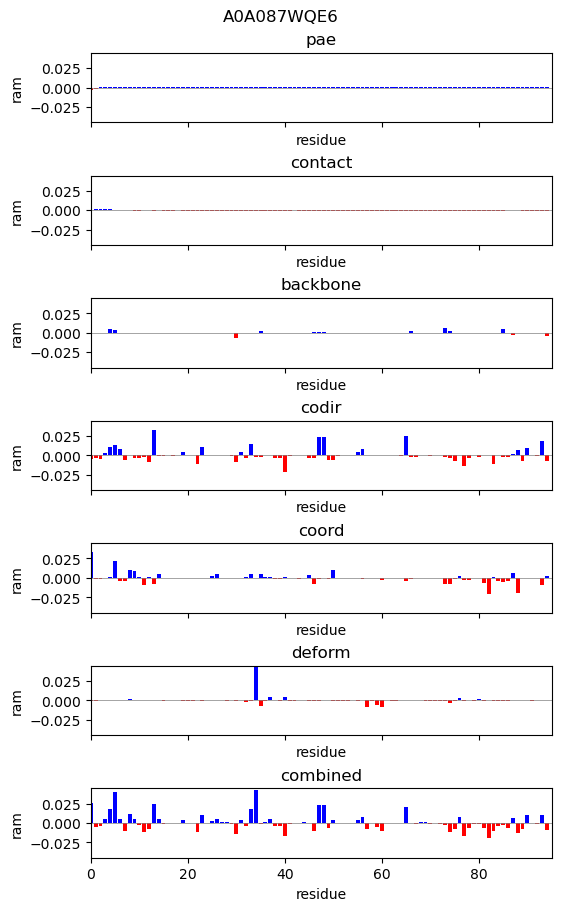

A0A078BPG0-AFv4_ram_no_relu.npy


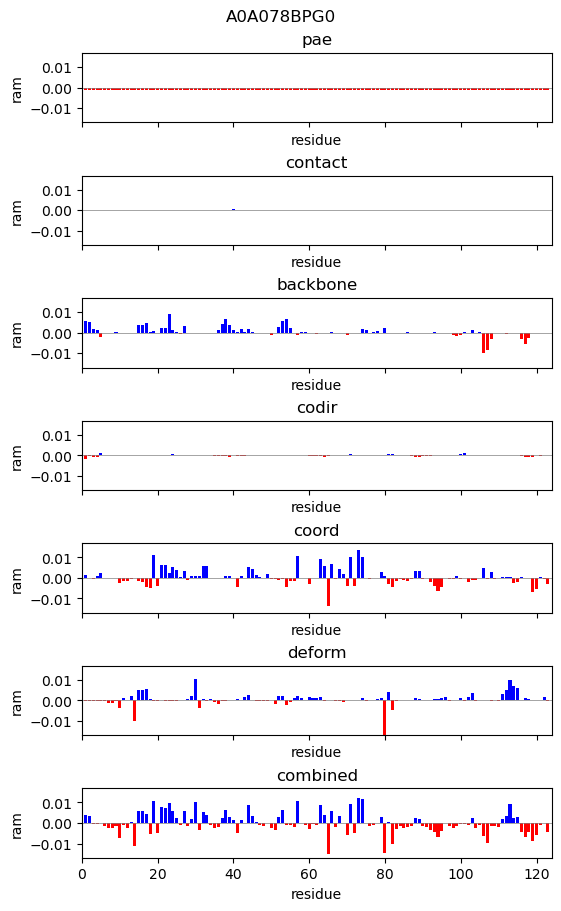

A0A061ACL6-AFv4_ram_no_relu.npy


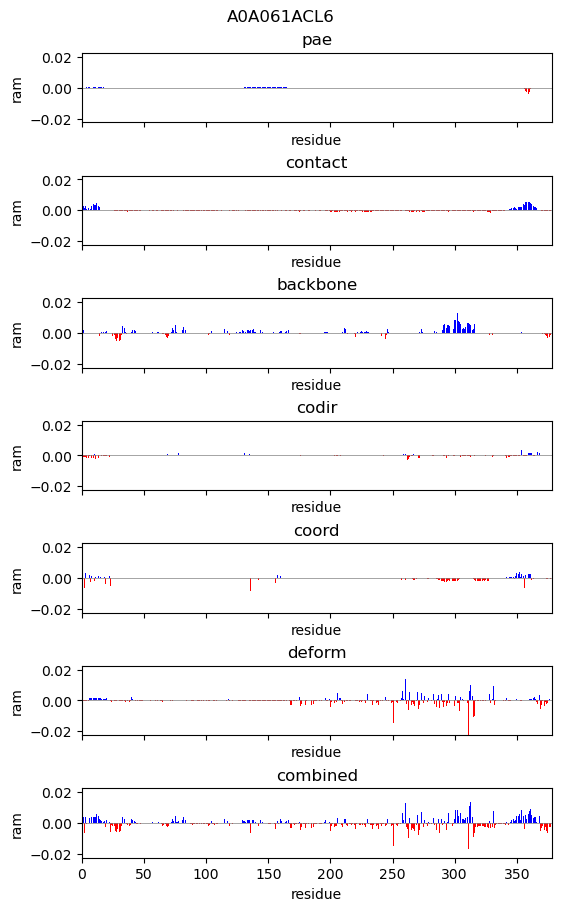

A0A061ACH9-AFv4_ram_no_relu.npy


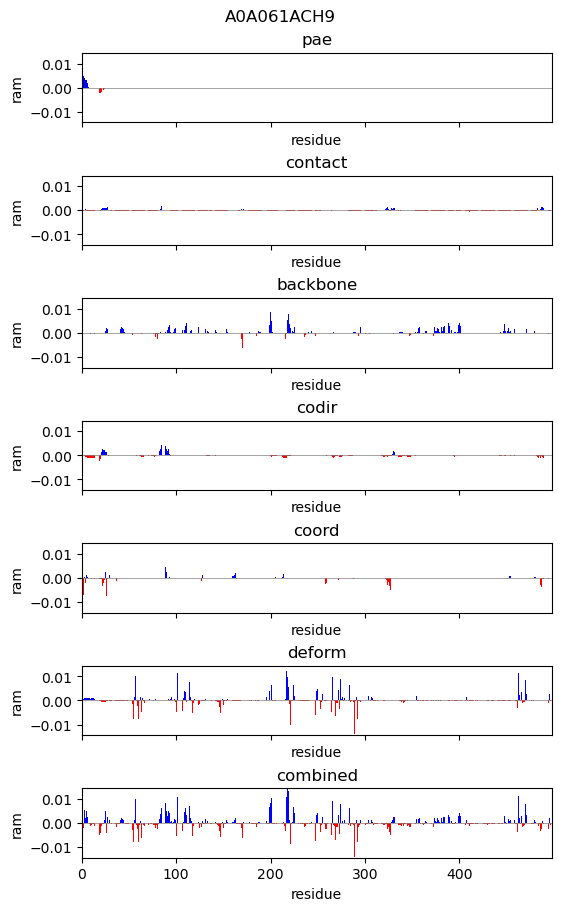

A0A023PXQ4-AFv4_ram_no_relu.npy


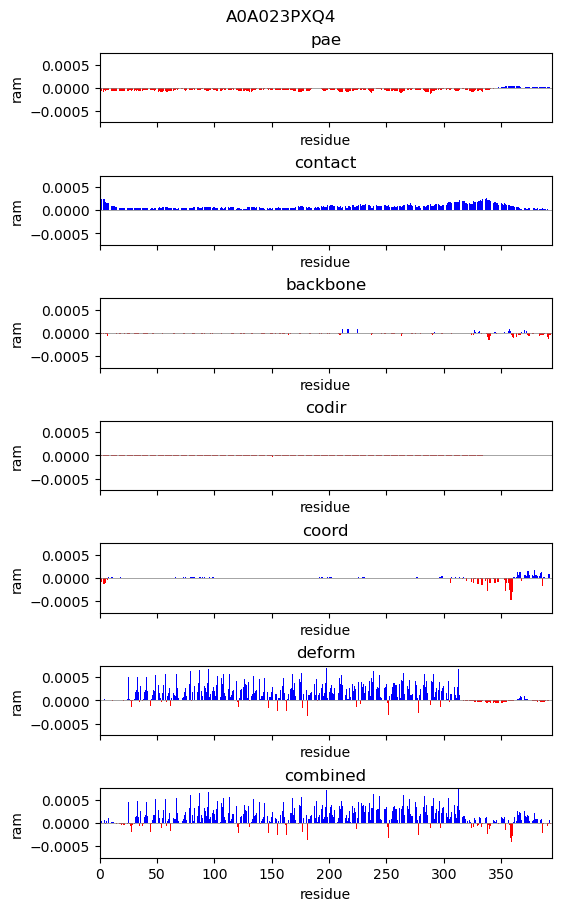

A0A087WNV1-AFv4_ram_no_relu.npy


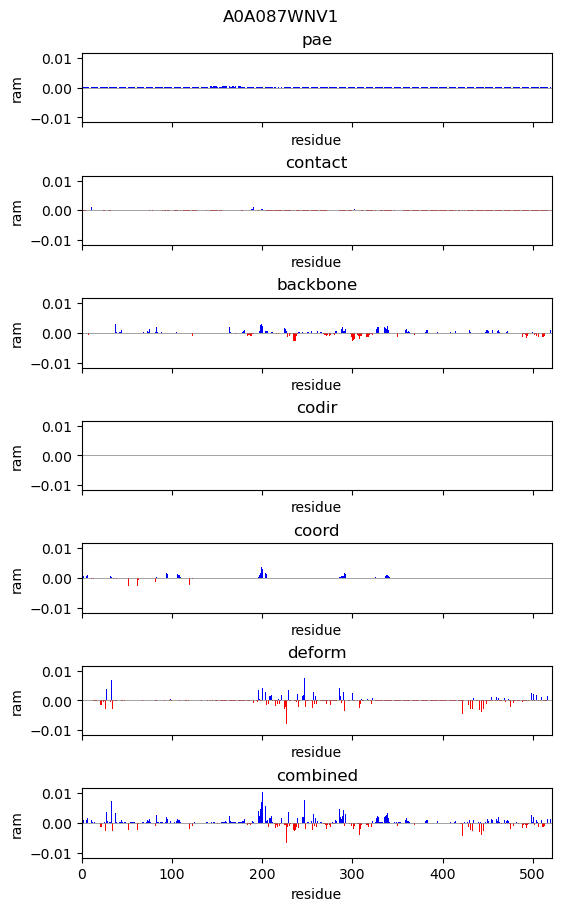

A0A061AJJ3-AFv4_ram_no_relu.npy


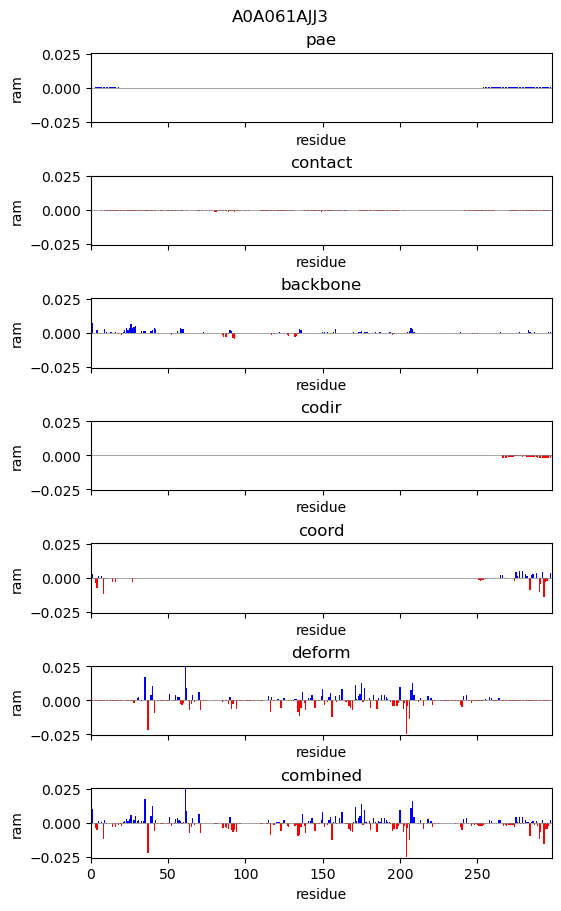

A0A068BIT0-AFv4_ram_no_relu.npy


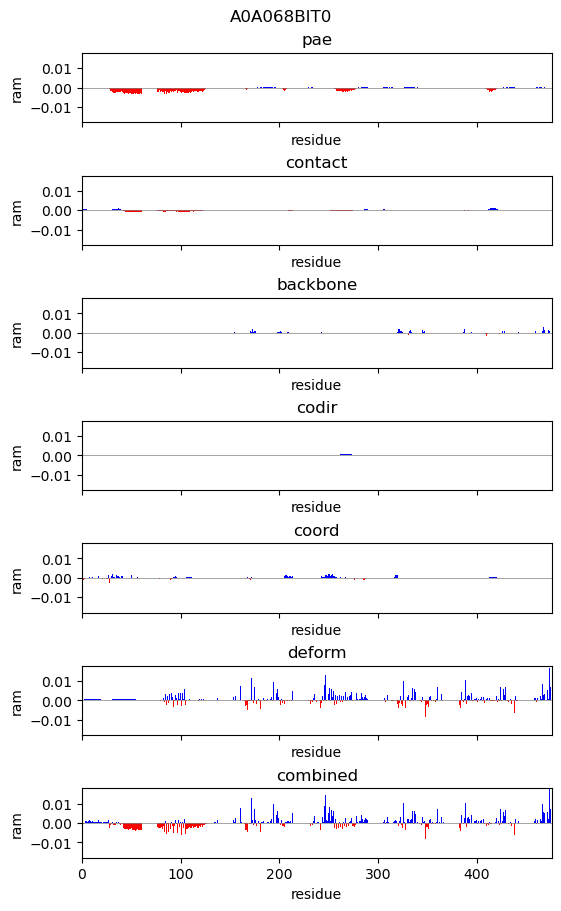

A0A068BIS6-AFv4_ram_no_relu.npy


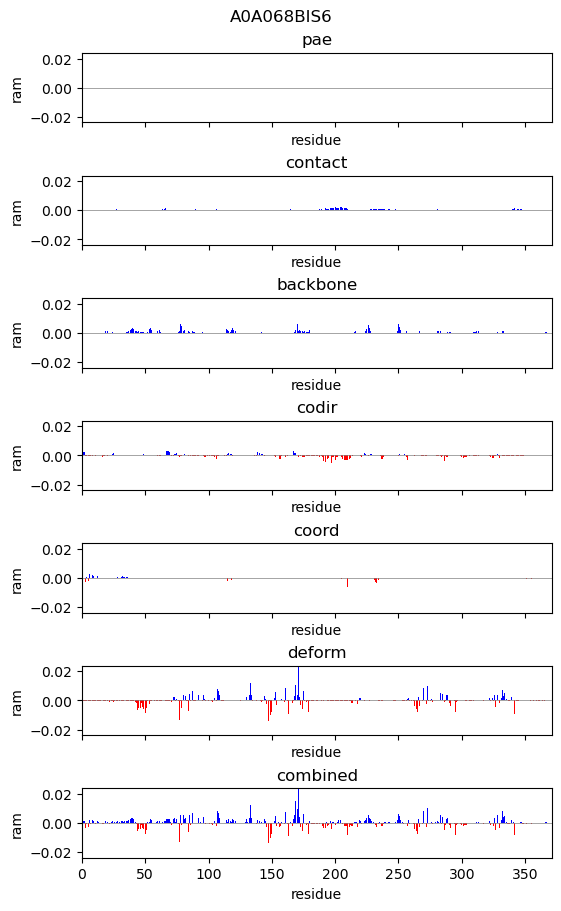

A0A087WPP8-AFv4_ram_no_relu.npy


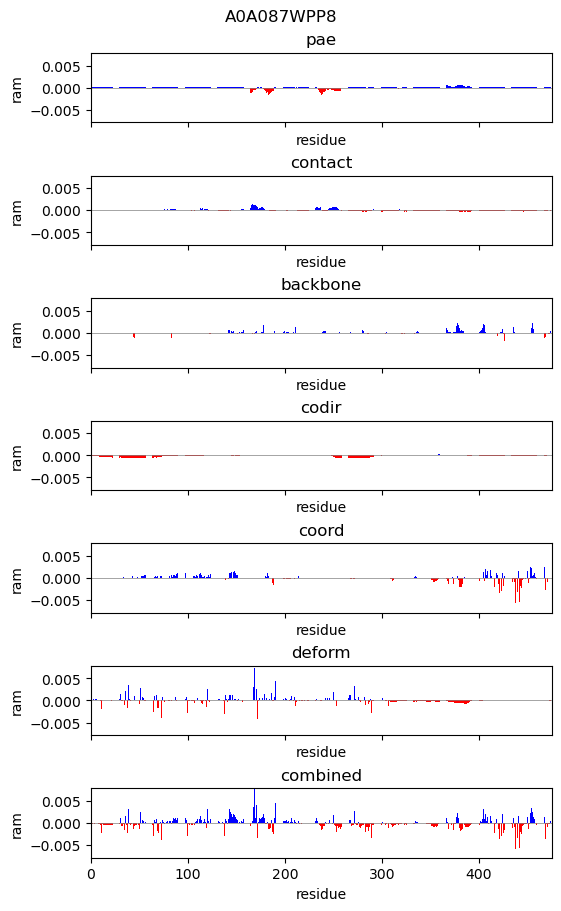

A0A061ACX4-AFv4_ram_no_relu.npy


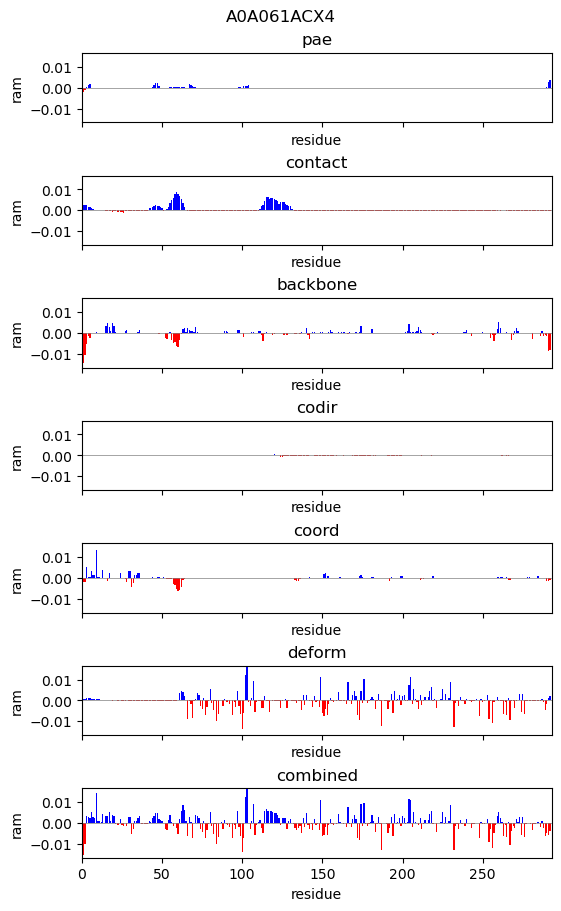

A0A087WRJ2-AFv4_ram_no_relu.npy


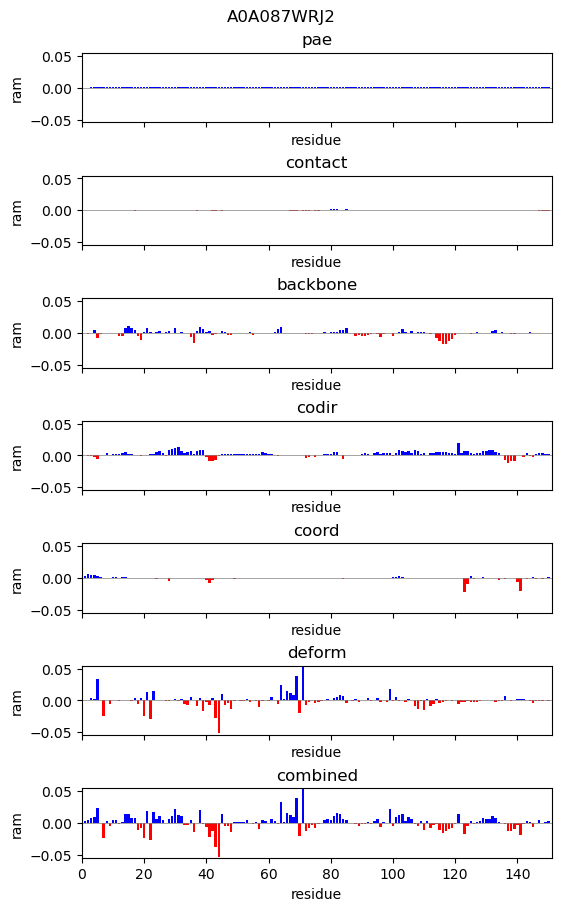

A0A077S9N1-AFv4_ram_no_relu.npy


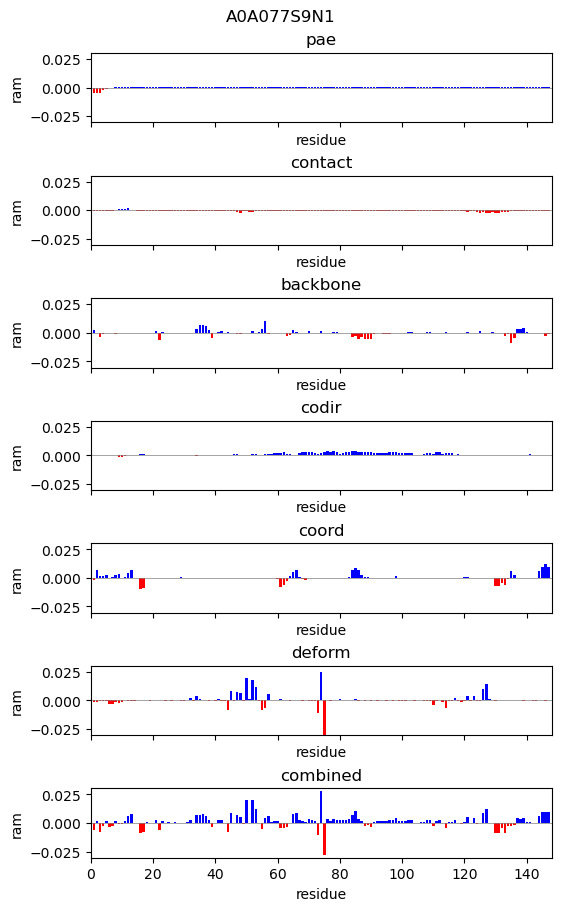

A0A087WRW6-AFv4_ram_no_relu.npy


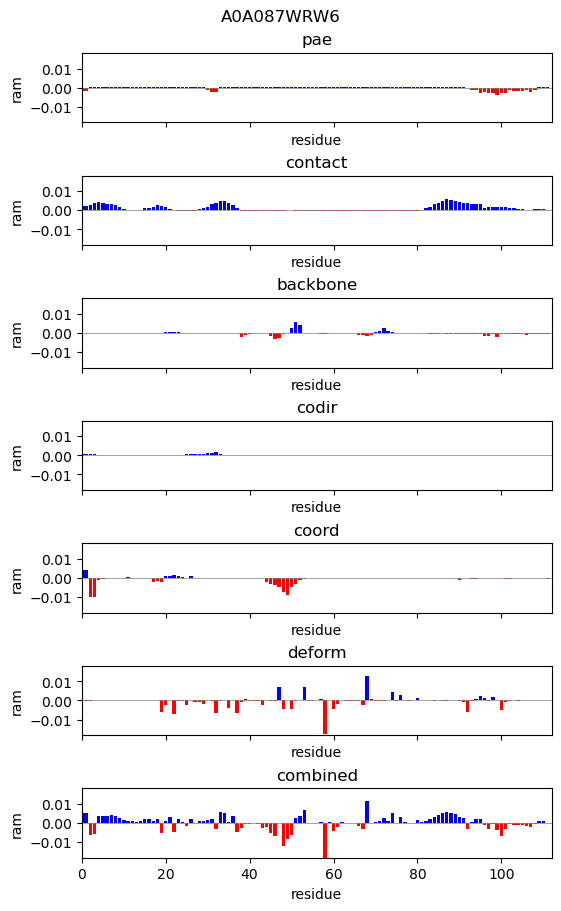

A0A087WQS2-AFv4_ram_no_relu.npy


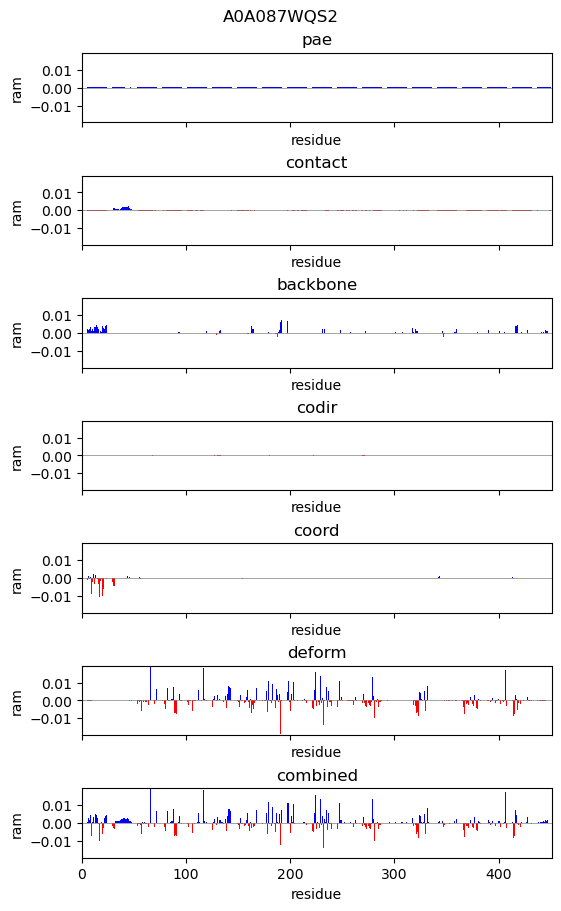

A0A061ACM7-AFv4_ram_no_relu.npy


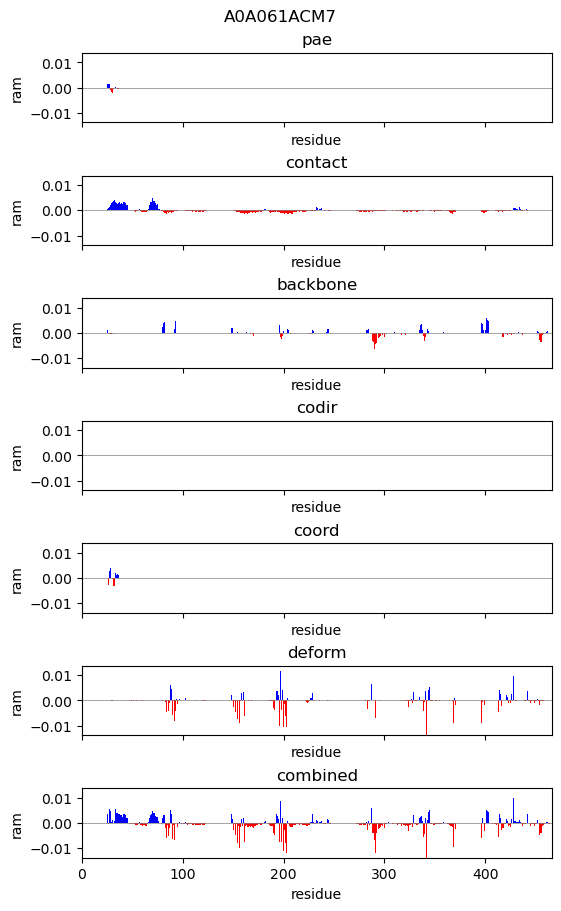

A0A061ACH4-AFv4_ram_no_relu.npy


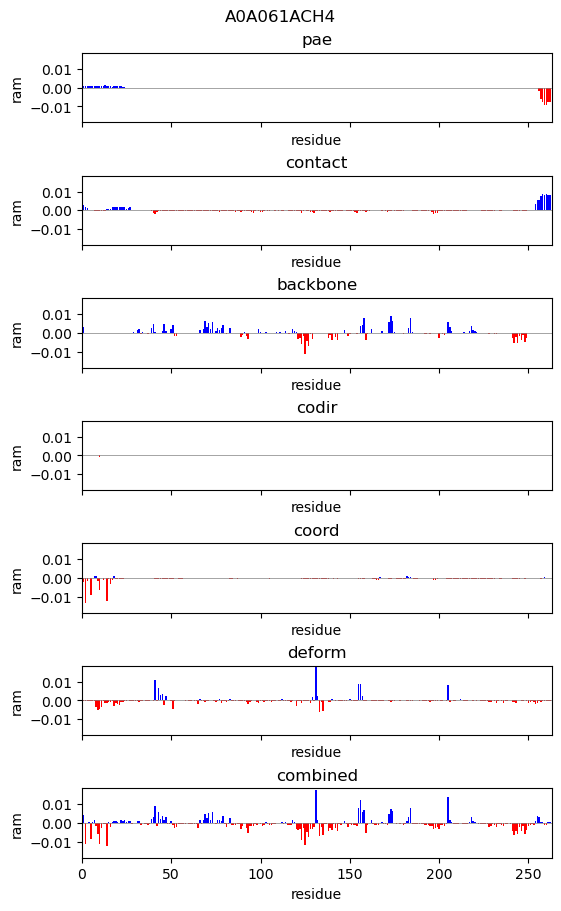

A0A087WST1-AFv4_ram_no_relu.npy


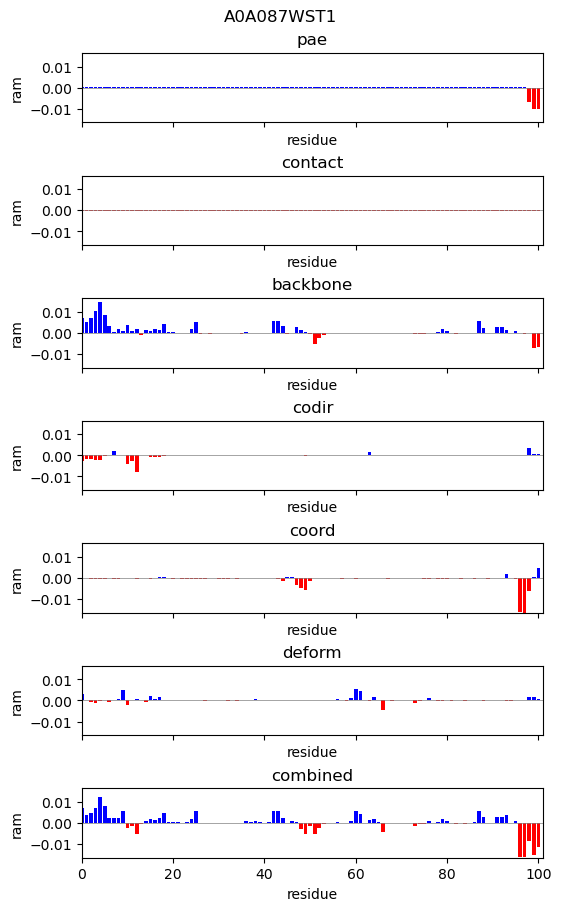

In [35]:
for ram_file in os.listdir(ram_dir):
    if 'no_relu' not in ram_file:
        continue
    print(ram_file)

    accession = ram_file.split('-')[0]

    ram_path = os.path.join(ram_dir, ram_file)
    ram = np.load(ram_path)

    fig, ax = plt.subplots(
        7, 1, sharex=True, sharey=True, figsize=(5.5, 9), layout='constrained' 
    )
    ax = ax.flatten()
    fig.suptitle(accession)

    n_res = ram.shape[1]
    res_idx = np.arange(n_res)

    y_abs_max = 0

    for i, edge_type in enumerate(['pae', 'contact', 'backbone', 'codir', 'coord', 'deform']):

        # ax[i].plot(ram[i])#, color='black', linewidth=0.5)
        ax[i].bar(res_idx, np.where(ram[i]>0, ram[i], 0), color='blue')
        ax[i].bar(res_idx, np.where(ram[i]<0, ram[i], 0), color='red')

        ax[i].axhline(y=0, c='gray', linewidth=0.5)

        ax[i].set_title(edge_type)

        ax[i].set_xlabel('residue')
        ax[i].set_ylabel('ram')
    
        # ax[i].set_xlim(0, ram[i].size)
        y_abs_max = max(y_abs_max, np.abs(ram[i]).max())

    i += 1
    ram_sum = np.sum(ram, axis=0)
    y_abs_max = max(y_abs_max, np.abs(ram_sum).max())

    # ax[i].plot(ram_sum)#
    ax[i].bar(res_idx, np.where(ram_sum>0, ram_sum, 0), color='blue')
    ax[i].bar(res_idx, np.where(ram_sum<0, ram_sum, 0), color='red')

    ax[i].axhline(y=0, c='gray', linewidth=0.5)

    ax[i].set_title('combined')

    ax[i].set_xlabel('residue')
    ax[i].set_ylabel('ram')

    ax[i].set_xlim(0, ram_sum.size)
    ax[i].set_ylim(-y_abs_max, y_abs_max)

    if save:
        plt.savefig(f'ram_no_relu-{accession}.png', dpi=300)
    plt.show()
    plt.close()
    
    # break

A0A061ACH8-AFv4_ram_no_relu.npy


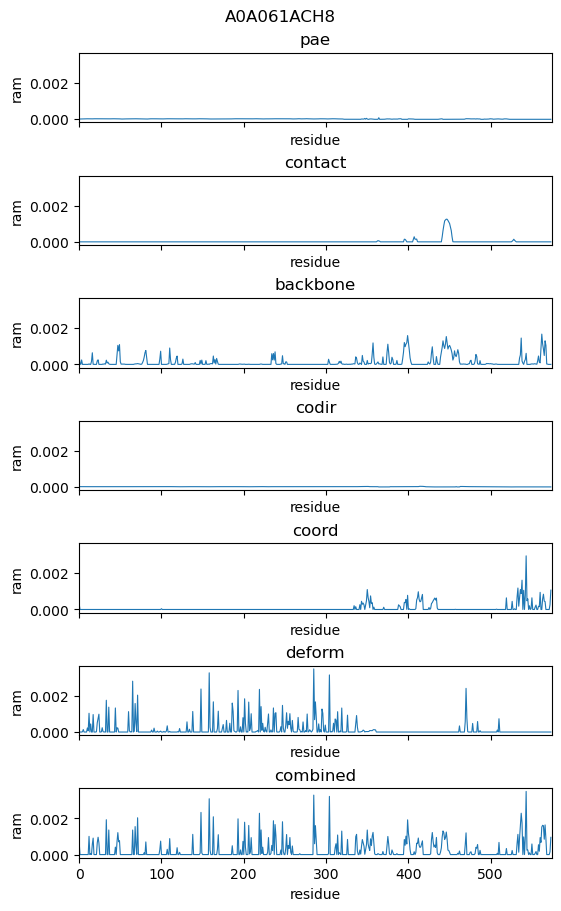

A0A087WR70-AFv4_ram_no_relu.npy


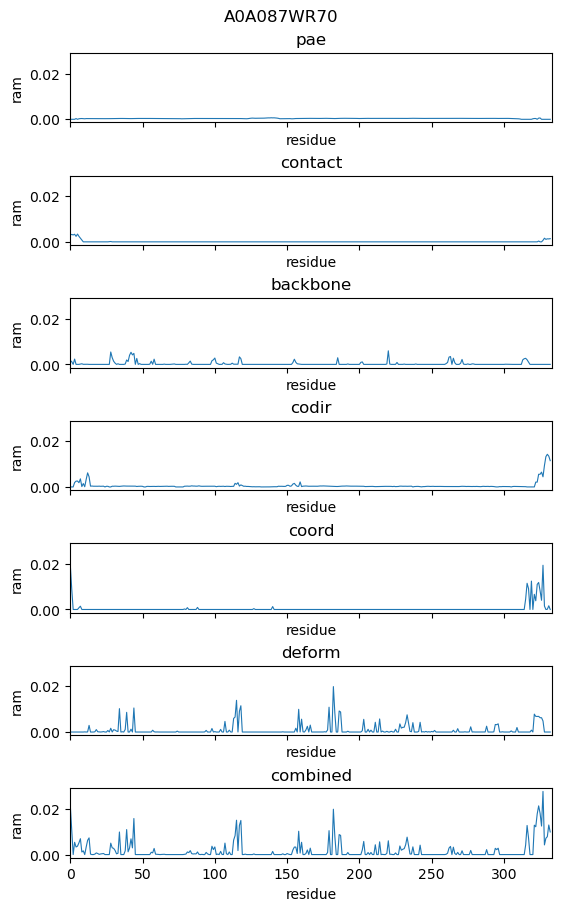

A0A023T778-AFv4_ram_no_relu.npy


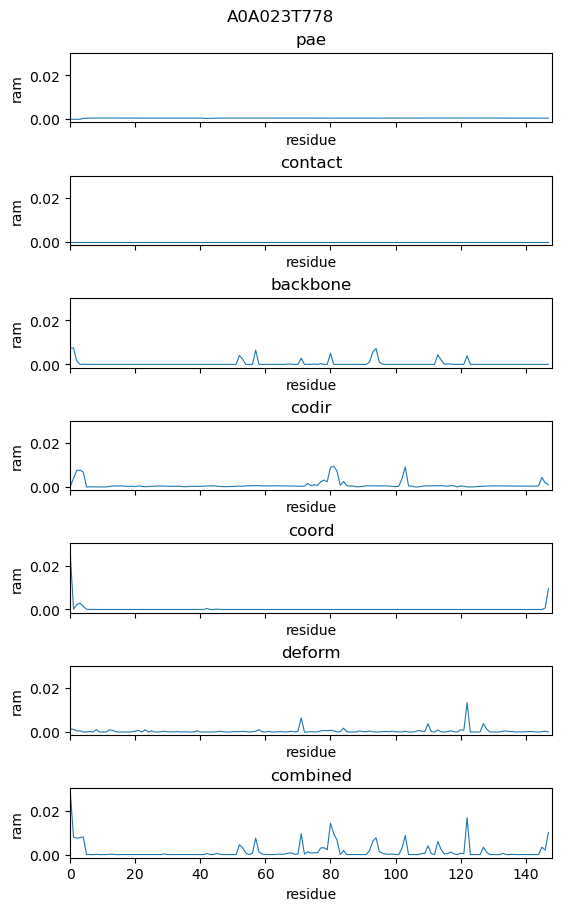

A0A087WQE6-AFv4_ram_no_relu.npy


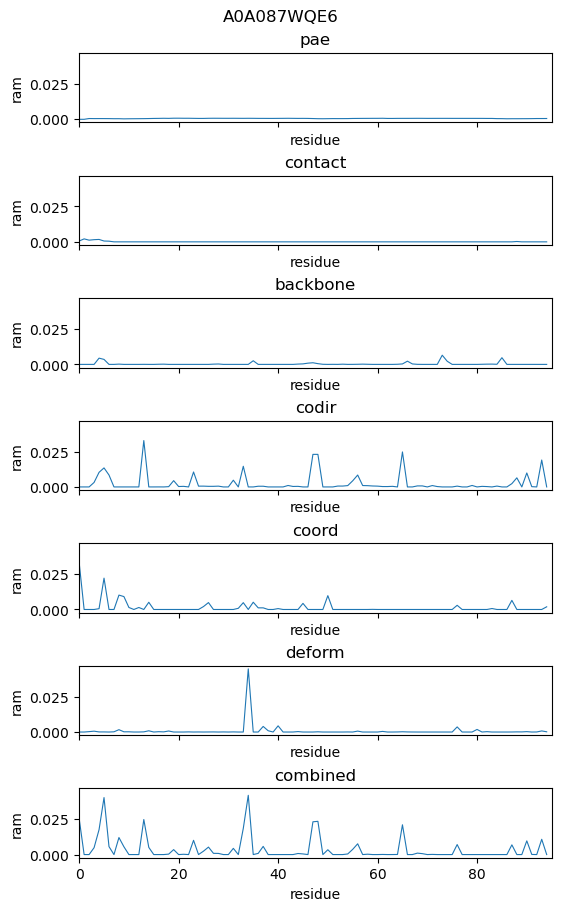

A0A078BPG0-AFv4_ram_no_relu.npy


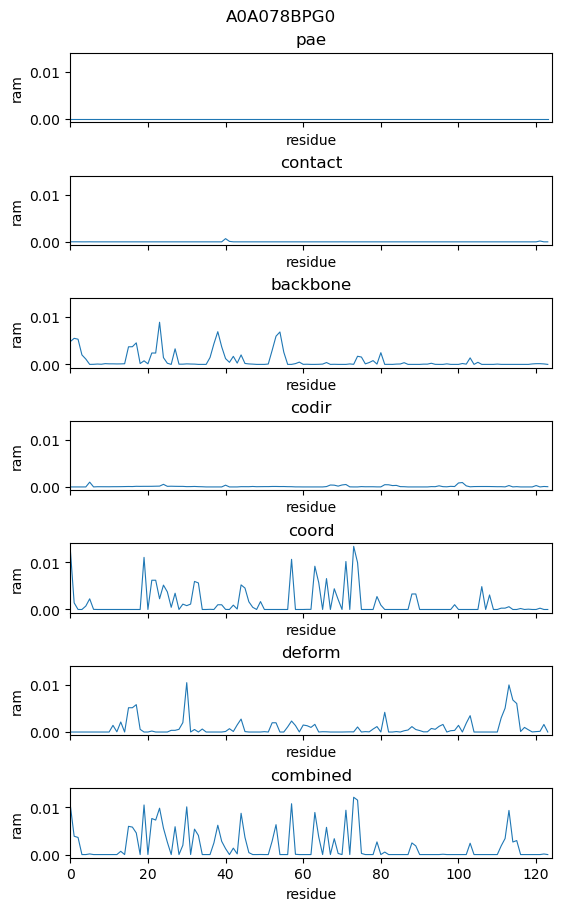

A0A061ACL6-AFv4_ram_no_relu.npy


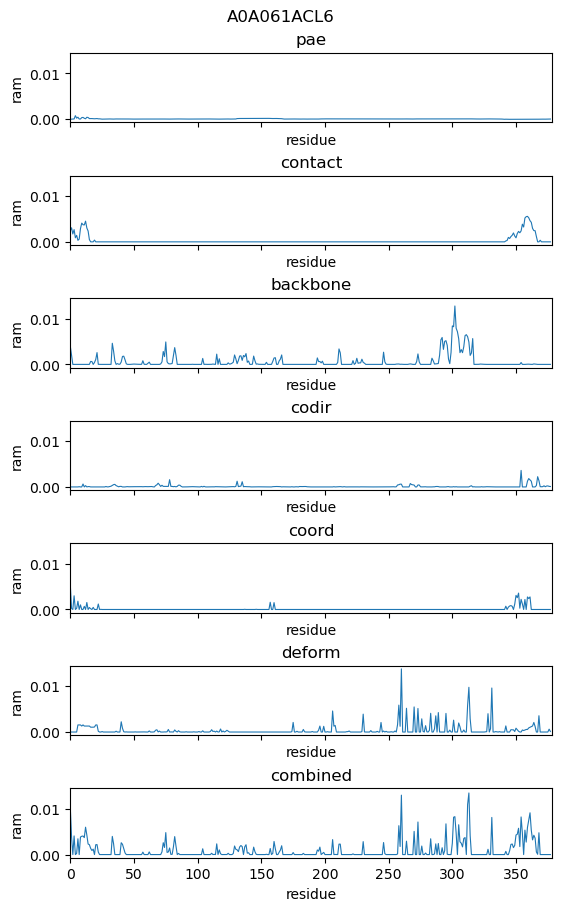

A0A061ACH9-AFv4_ram_no_relu.npy


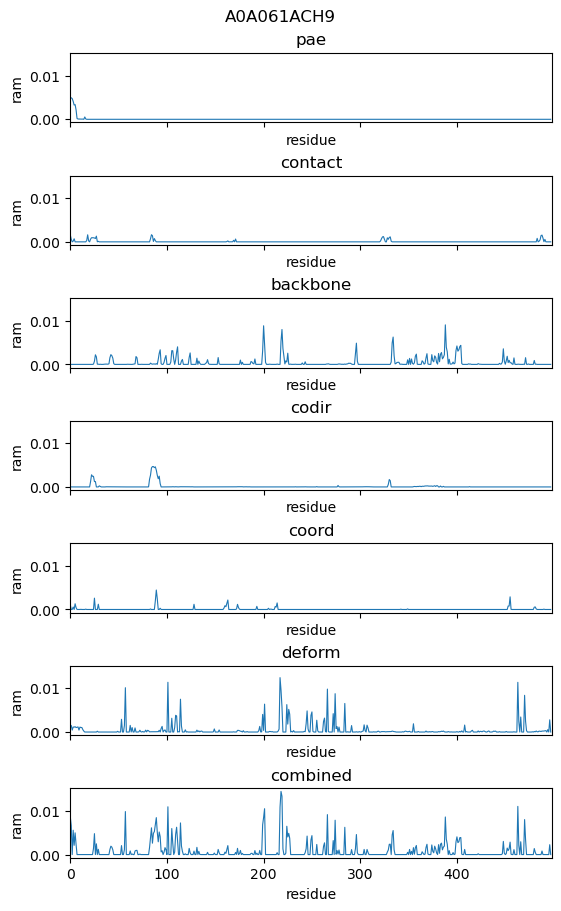

A0A023PXQ4-AFv4_ram_no_relu.npy


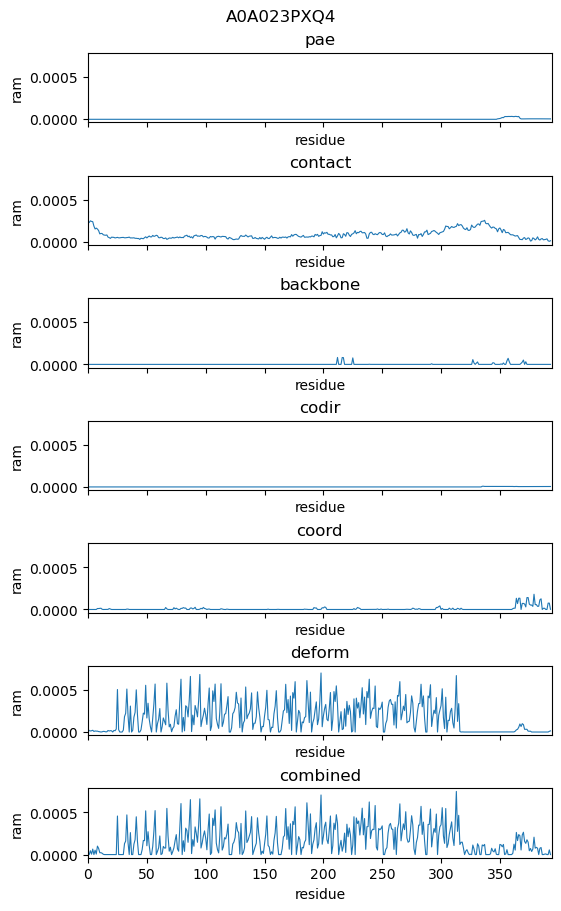

A0A087WNV1-AFv4_ram_no_relu.npy


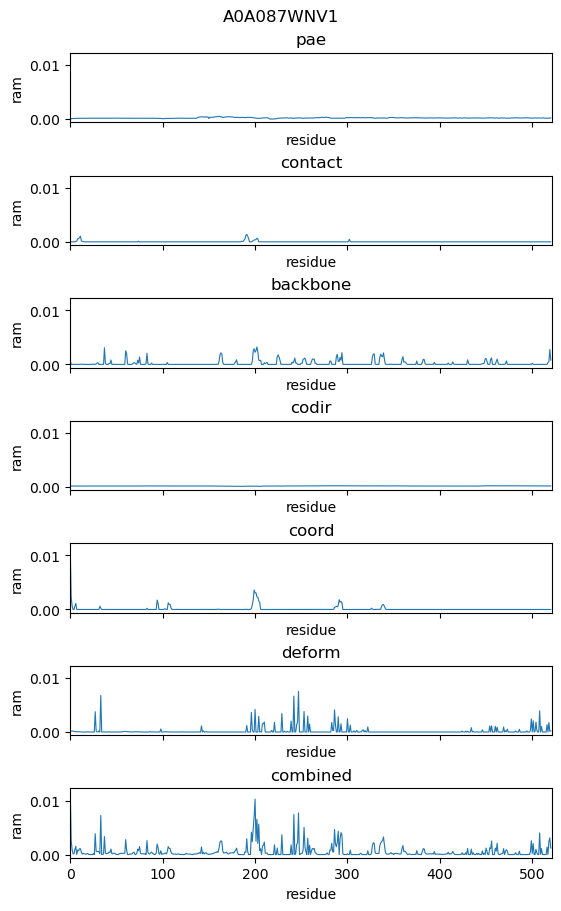

A0A061AJJ3-AFv4_ram_no_relu.npy


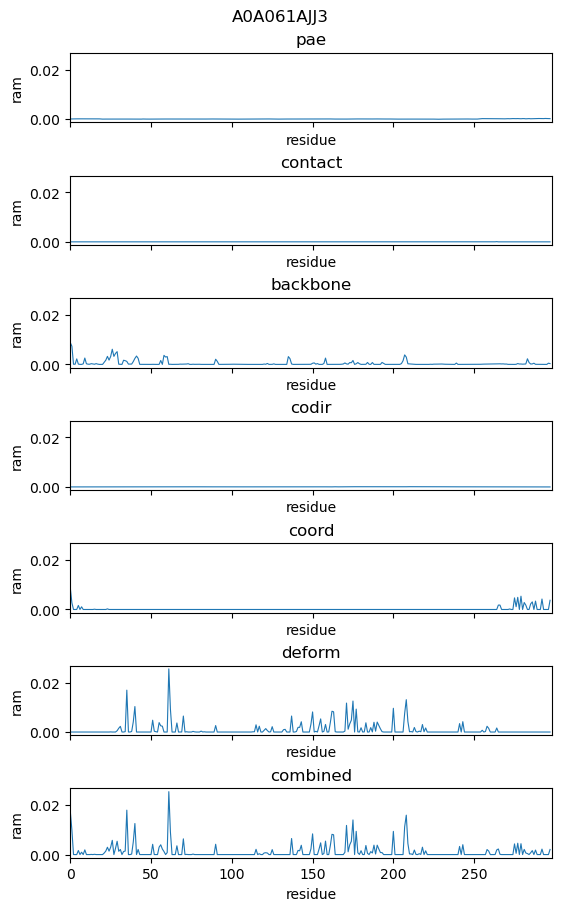

A0A068BIT0-AFv4_ram_no_relu.npy


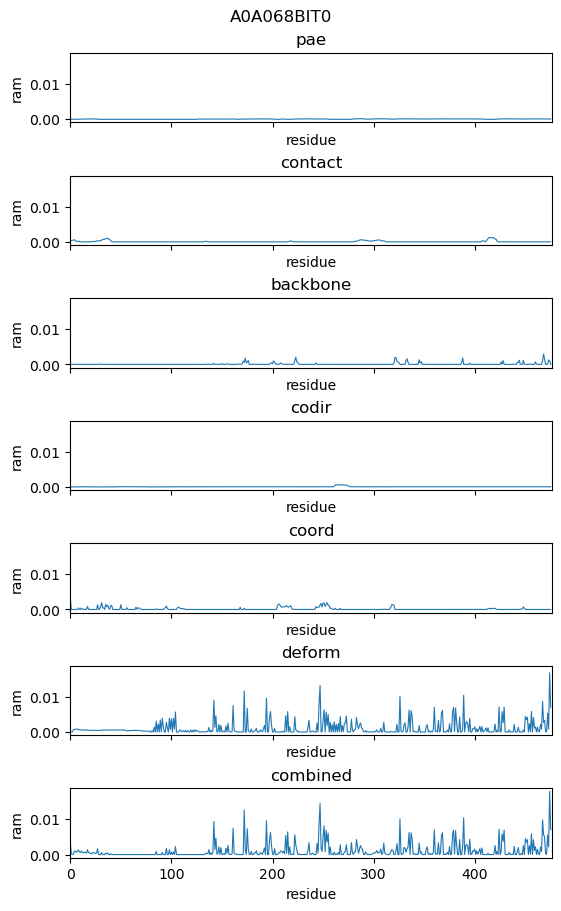

A0A068BIS6-AFv4_ram_no_relu.npy


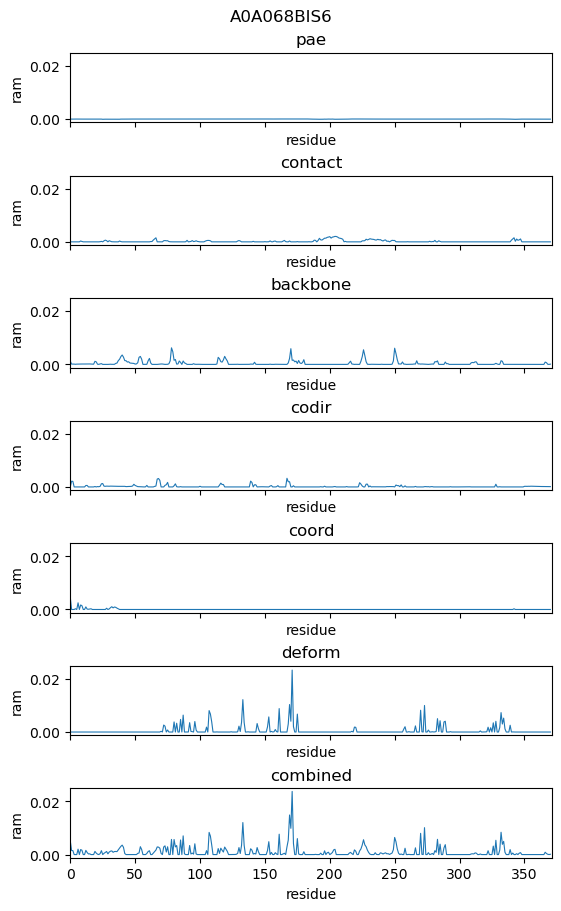

A0A087WPP8-AFv4_ram_no_relu.npy


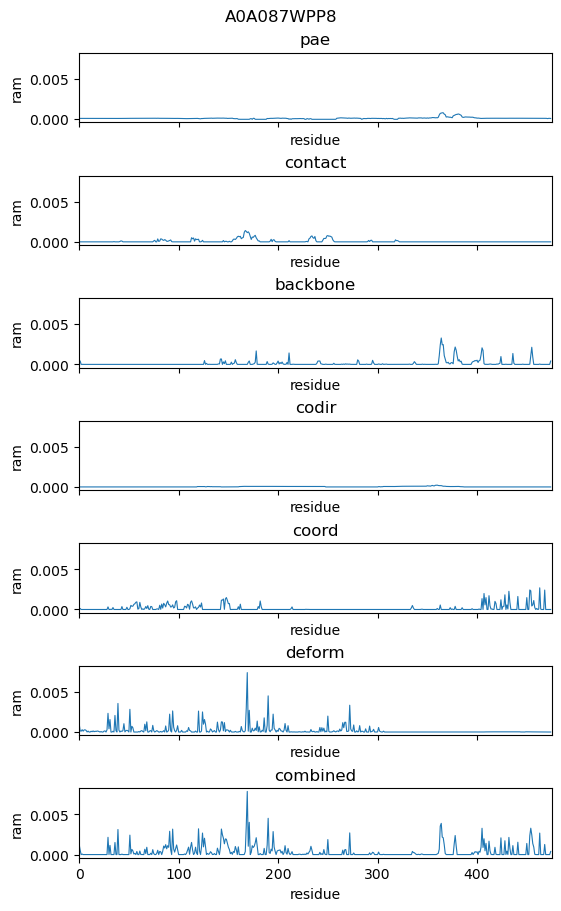

A0A061ACX4-AFv4_ram_no_relu.npy


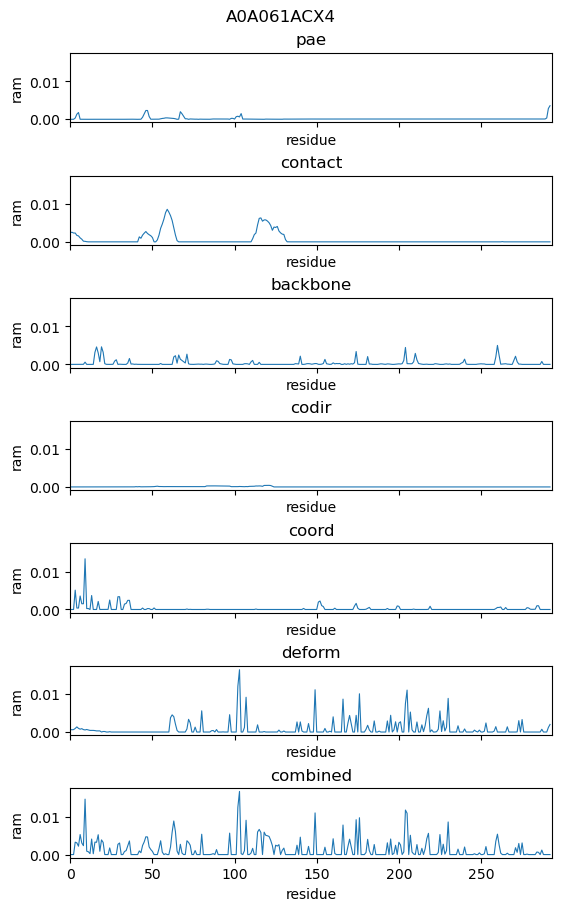

A0A087WRJ2-AFv4_ram_no_relu.npy


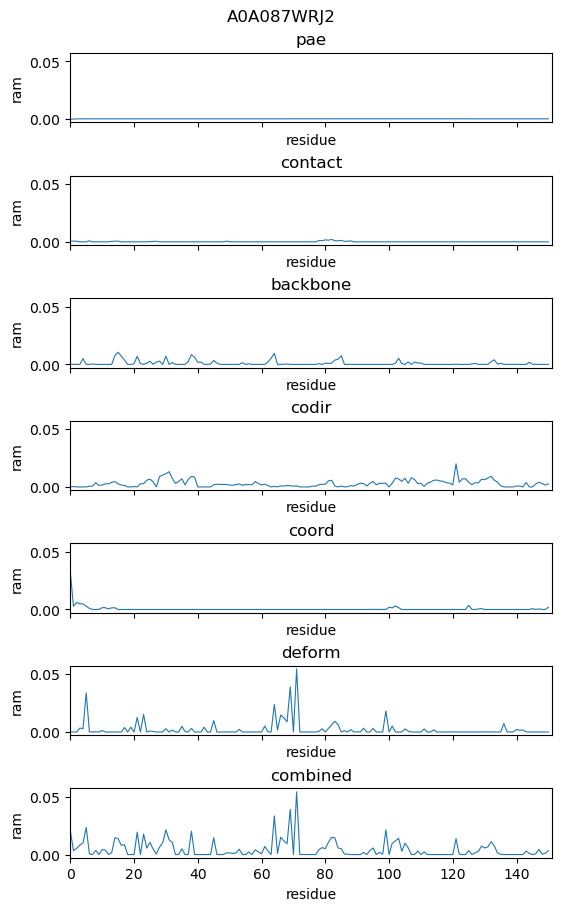

A0A077S9N1-AFv4_ram_no_relu.npy


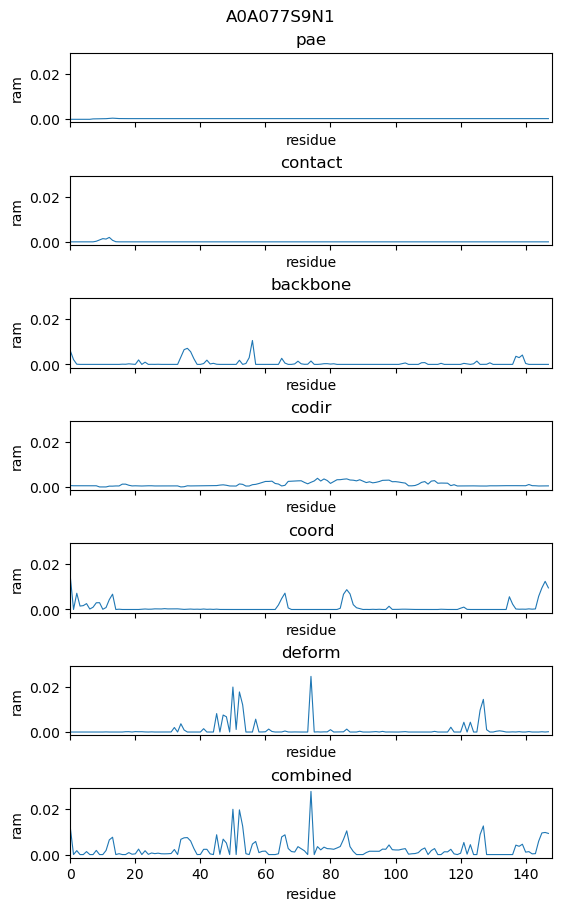

A0A087WRW6-AFv4_ram_no_relu.npy


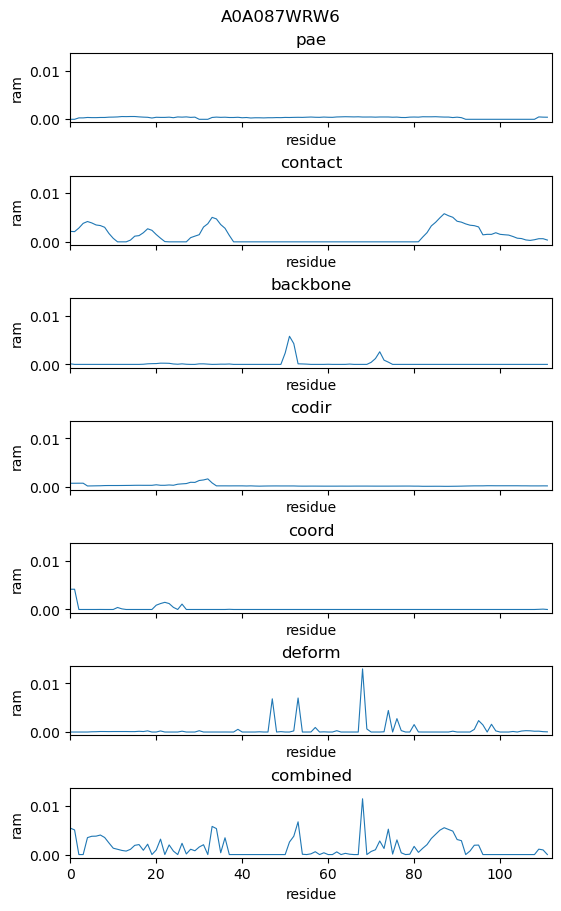

A0A087WQS2-AFv4_ram_no_relu.npy


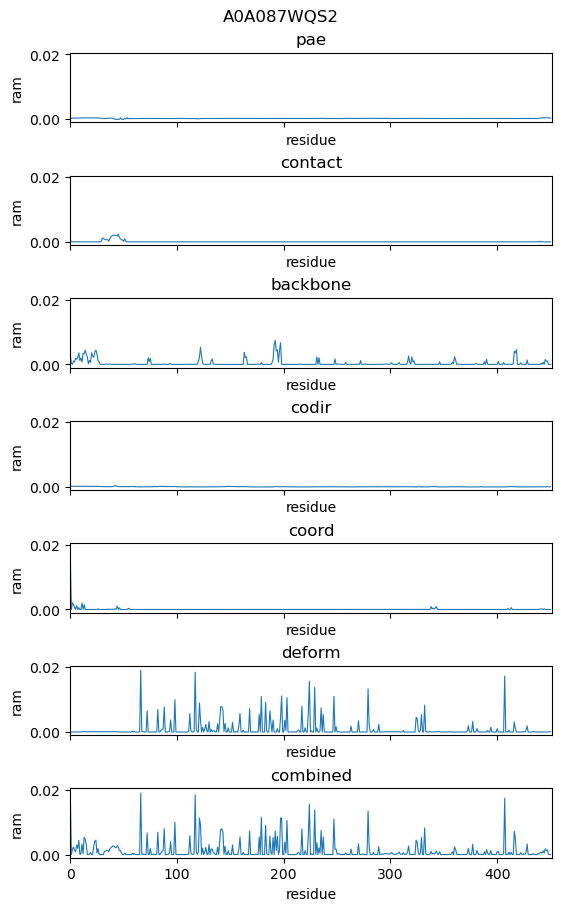

A0A061ACM7-AFv4_ram_no_relu.npy


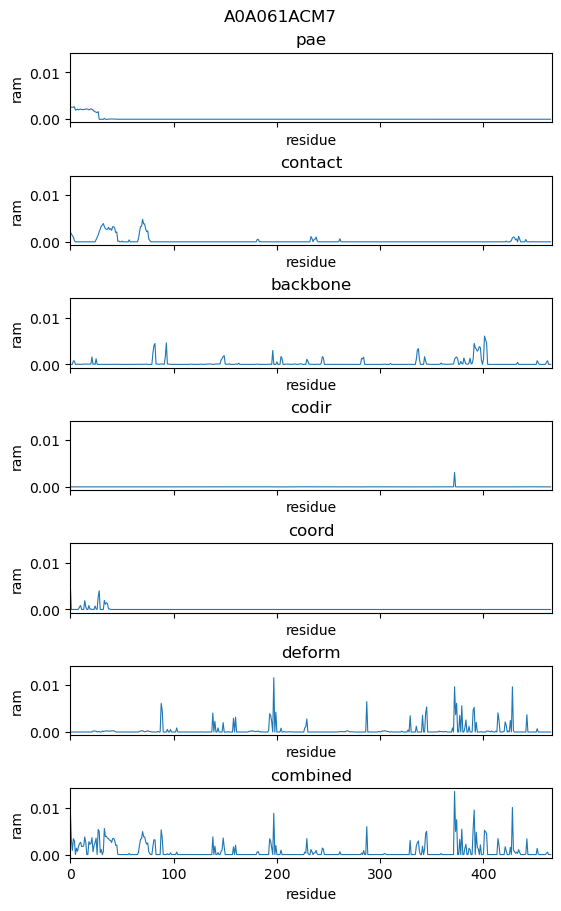

A0A061ACH4-AFv4_ram_no_relu.npy


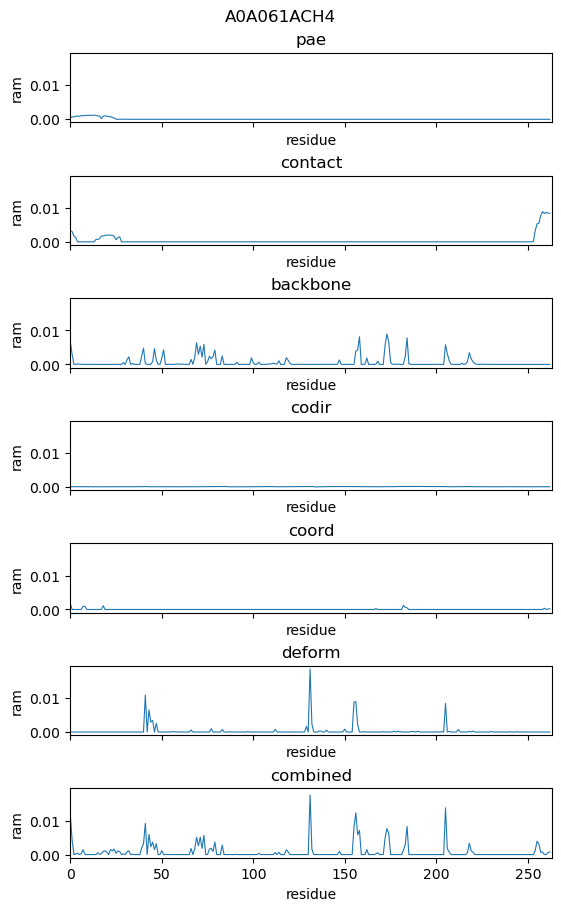

A0A087WST1-AFv4_ram_no_relu.npy


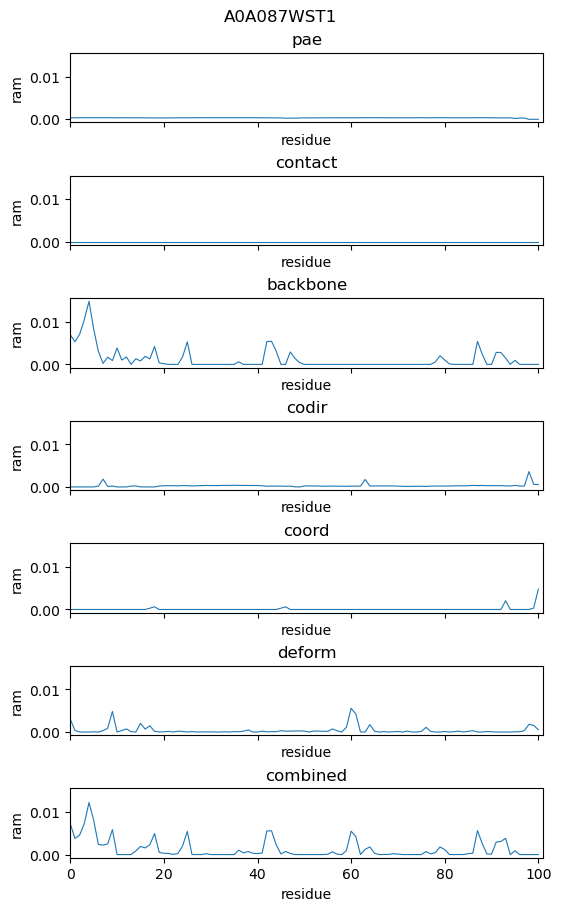

In [45]:
for ram_file in os.listdir(ram_dir):
    if 'no_relu' not in ram_file:
        continue
    print(ram_file)

    accession = ram_file.split('-')[0]

    ram_path = os.path.join(ram_dir, ram_file)
    ram = np.load(ram_path)

    fig, ax = plt.subplots(
        7, 1, sharex=True, sharey=True, figsize=(5.5, 9), layout='constrained' 
    )
    ax = ax.flatten()
    fig.suptitle(accession)

    n_res = ram.shape[1]
    res_idx = np.arange(n_res)

    y_abs_max = 0

    for i, edge_type in enumerate(['pae', 'contact', 'backbone', 'codir', 'coord', 'deform']):

        ax[i].plot(np.where(ram[i]>0, ram[i], 0), linewidth=0.8)
        # ax[i].bar(res_idx, np.where(ram[i]>0, ram[i], 0))

        # ax[i].bar(res_idx, np.where(ram[i]>0, ram[i], 0), color='blue')
        # ax[i].bar(res_idx, np.where(ram[i]<0, ram[i], 0), color='red')

        # ax[i].axhline(y=0, c='gray', linewidth=0.5)

        ax[i].set_title(edge_type)

        ax[i].set_xlabel('residue')
        ax[i].set_ylabel('ram')
    
        # ax[i].set_xlim(0, ram[i].size)
        # y_abs_max = max(y_abs_max, np.abs(ram[i]).max())

    i += 1
    ram_sum = np.sum(ram, axis=0)
    # y_abs_max = max(y_abs_max, np.abs(ram_sum).max())

    ax[i].plot(np.where(ram_sum>0, ram_sum, 0), linewidth=0.8)
    # ax[i].bar(res_idx, np.where(ram_sum>0, ram_sum, 0))

    # ax[i].bar(res_idx, np.where(ram_sum>0, ram_sum, 0), color='blue')
    # ax[i].bar(res_idx, np.where(ram_sum<0, ram_sum, 0), color='red')

    # ax[i].axhline(y=0, c='gray', linewidth=0.5)

    ax[i].set_title('combined')

    ax[i].set_xlabel('residue')
    ax[i].set_ylabel('ram')

    ax[i].set_xlim(0, ram_sum.size)
    # ax[i].set_ylim(-y_abs_max, y_abs_max)

    if save:
        plt.savefig(f'ram-{accession}.png', dpi=300)
    plt.show()
    plt.close()
    
    # break